In [2]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import random
import theano
theano.config.blas__ldflags = ''

We will select a size for every set of points generated by a distribution. Then, we will choose mu and sigma such that they will form a hill-like combination when all the distributions are mixed together. Then we will combine all the sets of points generated by the 3 distributions.

In [45]:
def generate_data(dataset_size):
    size1 = 130
    size2 = 170
    size3 = 200
    
    mu1 = 7
    sigma1 = 2
    mu2 = 10
    sigma2 = 2
    mu3 = 15
    sigma3 = 2
    
    data = [random.gauss(mu1, sigma1) for i in range(size1)] 
    data += [random.gauss(mu2, sigma2) for i in range(size2)]
    data += [random.gauss(mu3, sigma3) for i in range(size3)]
    
    return data
    
    

In [46]:
data = np.array(generate_data(500))
print(len(data))

500


Now, we will create the models and get the inference data for k=2, 3 and 4

In [47]:
clusters = [2, 3, 4]
models = []
idatas = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
            mu=np.linspace(data.min(), data.max(), cluster),sd=10, shape=cluster,
            transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=np.array(data))
        idata = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=123, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 86 seconds.
The acceptance probability does not match the target. It is 0.96310321215591, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 165 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8241773434109737, but should be close to 0.9. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.839149046865117, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


Now, we will visualize the inferred mixed distribution obtained by choosing 2, 3 and 4 clusters, respectively.

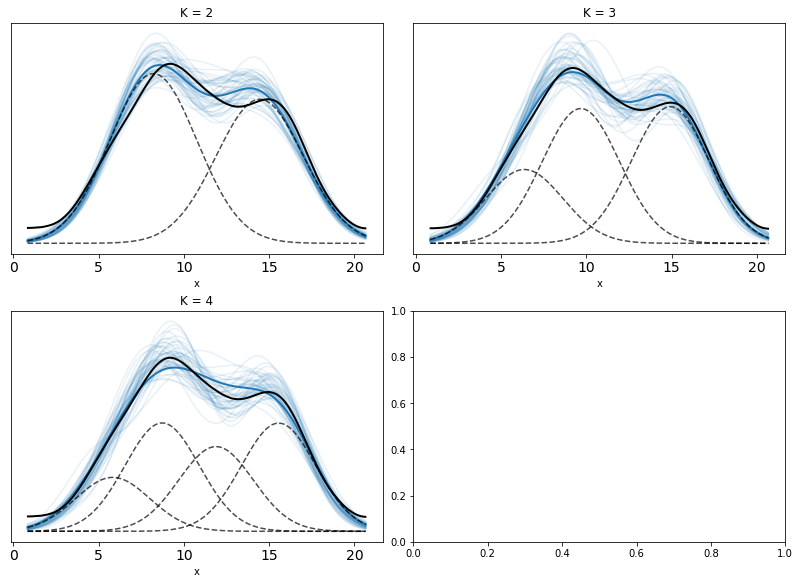

In [48]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
ax = np.ravel(ax)
x = np.linspace(data.min(), data.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * clusters[idx]).T
    
    for i in range(50):
        i_ = np.random.randint(0, posterior_x.samples.size)
        means_y = posterior_x['means'][:,i_]
        p_y = posterior_x['p'][:,i_]
        sd = posterior_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', alpha=0.1)
        
    means_y = posterior_x['means'].mean("samples")
    p_y = posterior_x['p'].mean("samples")
    sd = posterior_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
    az.plot_kde(data, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

K=3 seems to have generated distributions that are the closest to the data. But we cannot say if a model is better than the other just by seeing this plots, so we will compare them using WAIC and LOO.

In [53]:
comp = az.compare(dict(zip([str(c) for c in clusters], idatas)), method='BB-pseudo-BMA', ic="loo", scale="deviance")
comp

InvalidIndexError: slice(None, None, None)

In [50]:
az.waic(idatas[0])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1393.96    12.37
p_waic        3.99        -

In [51]:
az.waic(idatas[1])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1392.77    12.25
p_waic        5.45        -

In [52]:
az.waic(idatas[2])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1392.80    12.27
p_waic        5.82        -

It can be observed that for k=3 (idatas[1]) p_waic is the closest to 0.5 => the best model is the one with k=3

In [58]:
az.loo(idatas[0])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1393.97    12.37
p_loo        4.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [59]:
az.loo(idatas[1])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1392.78    12.25
p_loo        5.46        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [60]:
az.loo(idatas[2])

Computed from 4000 posterior samples and 500 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1392.82    12.27
p_loo        5.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      500  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

It can be observed that for k=3 (idatas[1]) p_loo is the closest to 0.5 => the best model is the one with k=3

So, considering the above conclusions (when using WAIC and LOO), the model with k=3 approximates data the best.